In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from behavenet.analyses.arhmm_utils import *
from behavenet.fitting.utils import get_lab_example
from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.data.utils import get_data_generator_inputs
from behavenet.fitting.utils import get_best_model_version, get_output_session_dir, get_expt_dir
import pickle
import pandas as pd
from shutil import copyfile

In [3]:
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
FONT_SIZE = 22
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': FONT_SIZE})
#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Myriad Pro']
plt.rcParams["font.family"] = "Times New Roman"

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

In [4]:
def plot_overlaid_states(lab, latents_trial,states_trial,ax,spc):
    spc = 1.1 * abs(latents_trial.max())
    n_latents = latents_trial.shape[1]
    plotting_latents = latents_trial + spc * np.arange(n_latents)
    ax.imshow(states_trial[None,:],
               aspect="auto",
               extent=(0, len(latents_trial), min(-spc-1,np.min(plotting_latents)), max(spc*n_latents,np.max(plotting_latents))),
               cmap="jet", alpha=0.5)
    ax.plot(plotting_latents, '-k', lw=1)
    yticks = spc * np.arange(n_latents)
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(np.arange(n_latents)[::2])

    if lab =='musall':
        ax.set_xticks([0,200,400])
        ax.set_xticklabels((np.asarray([0,200,400])/hparams['frame_rate']).astype('int'))
        ax.axvline(x=189,ymin=0,ymax=1,c="black",linewidth=3, clip_on=False)
        ax.axvline(x=189*2,ymin=0,ymax=1,c="black",linewidth=3, clip_on=False)
        #ax.axvline(x=189*5,ymin=0,ymax=1,c="black",linewidth=3, clip_on=False)
    elif latents_trial.shape[0]==1000:
        ax.set_xticks([0,200,400,600,800,1000])
        ax.set_xticklabels((np.asarray([0,200,400,600,800,1000])/hparams['frame_rate']).astype('int'))

In [5]:
import scipy.io as sio
trial_info = sio.loadmat(
    '/media/mattw/data/musall/vistrained/mSM36/05-Dec-2017/trialmarkers.mat')

In [8]:
kappa = 0
n_states = 8
# labs = ['musall', 'steinmetz', 'steinmetz-face']
# dataset_names = ['WFCI', 'NP', 'NP-zoom']

labs = ['musall']
dataset_names = ['WFCI']

basedir = '/media/mattw/data/results/behavenet/'

fig_overview = plt.figure(figsize=(22,18))

#gs = gridspec.GridSpec(24*2,8,hspace=3)
gs_top = plt.GridSpec(3,2,bottom=.5,left=0.2,hspace=.2)
gs_bottom_left = plt.GridSpec(24,1,top=.43,right=.4)
gs_bottom_right = plt.GridSpec(2,3,top=.43,left=.45,width_ratios=[0.45,0.33,0.22])

for i_lab, lab in enumerate(labs):

    hparams = {
        'data_dir': '/media/mattw/data/',
        'tt_save_path': basedir,
        'model_type': '',
        'model_class': 'arhmm',
        'experiment_name': 'grid_search',
        'n_arhmm_states': n_states,
        'kappa': kappa,
        'n_lags': 1,
        'noise_type': 'gaussian',
        'ae_experiment_name': 'ae-dim-search',
        'n_ae_latents': 8,
        'ae_model_type': 'conv',
    }

    get_lab_example(hparams, lab)
    if lab == 'musall':
        hparams['animal'] = 'mSM36'
        hparams['session'] = 'all'
        
    hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
    hparams['expt_dir'] = get_expt_dir(hparams)
    
    ## Get best version/model
    best_version = get_best_model_version(
        hparams['expt_dir'],measure='val_ll',best_def='max')[0]
    hmm = pickle.load(open(os.path.join(
        hparams['expt_dir'],best_version,'best_val_model.pt'),'rb'))
    
    ## Get latents
    hparams = pickle.load(open(os.path.join(
        hparams['expt_dir'],best_version,'meta_tags.pkl'),'rb'))
    print('best n lags '+str(hparams['n_lags']))
    hparams['ae_model_path'] = basedir+hparams['ae_model_path'].split('results/')[1]
    print(os.path.join(hparams['ae_model_path'],'latents.pkl'))
    all_latents = pickle.load(open(os.path.join(hparams['ae_model_path'],'latents.pkl'),'rb')) 
    copyfile(os.path.join(results_dir,best_version,'syllable_behavior_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'_nlags_'+str(hparams['n_lags'])+'.mp4'),'behavenet_figs/'+dataset_names[i_lab]+'_syllable_behavior_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'_nlags_'+str(hparams['n_lags'])+'.mp4')
    get_lab_example(hparams, lab)
    
    # Get real latents/states
    trial_idxs = {}
    latents={}
    states={}
    for data_type in ['train','val','test']:
        trial_idxs[data_type] = all_latents['trials'][data_type]
        latents[data_type] = [all_latents['latents'][i_trial] for i_trial in trial_idxs[data_type]]
        states[data_type] = [hmm.most_likely_states(x) for x in latents[data_type]]

#     # Get generative latents/states
#     generative_states = []
#     generative_latents = []
#     for i in range(len(latents['test'])):
#         these_generative_states, these_generative_latents = hmm.sample(latents['test'][0].shape[0]+700)
#         generative_states.append(these_generative_states[700:])
#         generative_latents.append(these_generative_latents[700:])
        
#     ax1 = plt.subplot(gs_top[i_lab, 0])
#     ax2 = plt.subplot(gs_top[i_lab, 1])
    
#     ax1.set_ylabel('Latent number')
#     ax1.text(-.2,.5,dataset_names[i_lab],transform=ax1.transAxes,horizontalalignment='center',)
#     #ax1.set_ylabel(labs_capped[i_lab],rotation='horizontal',labelpad=60)
#     spc=7
    
#     if i_lab==0:
#         ax1.set_title('Inferred states & latents')
#         ax2.set_title('Generated states & latents')
    
#     if lab == 'musall':
#         plot_latents = np.concatenate((latents['test'][2],latents['test'][3],latents['test'][4]),axis=0)
#         plot_states = np.concatenate((states['test'][2],states['test'][3],states['test'][4]),axis=0)
#         plot_generative_latents = np.concatenate((generative_latents[4],generative_latents[5],generative_latents[6]),axis=0)
#         plot_generative_states = np.concatenate((generative_states[4],generative_states[5],generative_states[6]),axis=0)
        
#     else:
#         plot_latents = latents['test'][2]
#         plot_states = states['test'][2]
#         plot_generative_latents = generative_latents[4]
#         plot_generative_states = generative_states[4]
#     plot_overlaid_states(lab, plot_latents,plot_states,ax1,spc=spc)
#     plot_overlaid_states(lab, plot_generative_latents,plot_generative_states,ax2,spc=spc)
    

#     ## Plot example generated images
#     ae_model_file = os.path.join(hparams['ae_model_path'],'best_val_model.pt')
#     ae_arch = pickle.load(open(os.path.join(hparams['ae_model_path'],'meta_tags.pkl'),'rb'))
#     ae_model = AE(ae_arch)
#     ae_model.load_state_dict(torch.load(ae_model_file, map_location=lambda storage, loc: storage))
#     ae_model.eval()
    
#     generative_frames = ae_model.decoding(torch.tensor(generative_latents[4]).float(), None, None).cpu().detach().numpy()
    
#     if lab =='musall':
#          generative_frames = np.transpose(generative_frames,(0,1,3,2))
#     generative_frames = np.concatenate([generative_frames[:,j] for j in range(generative_frames.shape[1])],axis=2)     
           
    
#     #sample_frames = [np.floor(0.3*generative_frames.shape[0]).astype('int'),np.floor(0.7*generative_frames.shape[0]).astype('int')]
#     sample_frames = [np.floor(0.4*generative_frames.shape[0]).astype('int'),np.floor(0.9*generative_frames.shape[0]).astype('int')]
    
#     ax_ex1 = plt.subplot(gs_bottom_right[0,i_lab])
#     ax_ex1.imshow(generative_frames[sample_frames[0]],vmin=0,vmax=1,cmap='gray')
#     ax_ex1.set_xticks([])
#     ax_ex1.set_yticks([])
#     [s.set_visible(False) for s in ax_ex1.spines.values()]
#     ax_ex1.set_title(dataset_names[i_lab])
    
#     ax_ex2 = plt.subplot(gs_bottom_right[1,i_lab])
#     ax_ex2.imshow(generative_frames[sample_frames[1]],vmin=0,vmax=1,cmap='gray')
#     ax_ex2.set_xticks([])
#     ax_ex2.set_yticks([])    
#     [s.set_visible(False) for s in ax_ex2.spines.values()]
    
#     ## Make real vs generated videos
#     hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
#     hparams['data_dir'] = '/Volumes/paninski-locker/data/'

#     hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
#     ids = {
#         'lab': hparams['lab'],
#         'expt': hparams['expt'],
#         'animal': hparams['animal'],
#         'session': hparams['session']}
#     data_generator = ConcatSessionsGenerator(
#         hparams['data_dir'], ids,
#         signals=signals, transforms=transforms, load_kwargs=load_kwargs,
#         device=hparams['device'], as_numpy=hparams['as_numpy'],
#         batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])


#     #make_real_vs_nonconditioned_generated_movies('behavenet_figs/', hparams, latents['test'], generative_latents, data_generator, trial_idxs=trial_idxs['test'])
#     copyfile(os.path.join(results_dir,best_version,'real_vs_generated_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'_nlags_'+str(hparams['n_lags'])+'.mp4'),'behavenet_figs/'+dataset_names[i_lab]+'_real_vs_generated_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'_nlags_'+str(hparams['n_lags'])+'.mp4')
    
#     ## Plot trial structure
#     if lab=='musall':
#         n_trials=24
#         trial_vec = np.random.choice(np.arange(0,len(states['test'])),size=(n_trials,),replace=False)

#         for i_trial in range(n_trials):

#             axes = plt.subplot(gs_bottom_left[i_trial,0])
#             axes.imshow(states['test'][trial_vec[i_trial]][None,:], 
#                            aspect="auto", 
#                            extent=(0, len(states['test'][trial_vec[i_trial]]), 0, 1), 
#                            cmap="jet", alpha=0.35)
#             axes.axvline(x=trial_info['leverIn'][0,trial_idxs['test'][trial_vec[i_trial]]],ymin=0,ymax=1,c="g",linewidth=2,clip_on=False, label='Levers in',alpha=1)
#             axes.axvline(x=trial_info['stimTime'][0,trial_idxs['test'][trial_vec[i_trial]]],ymin=0,ymax=1,c="r",linewidth=2, clip_on=False , label='Stimulus onset',alpha=1)
#             axes.axvline(x=trial_info['spoutTime'][0,trial_idxs['test'][trial_vec[i_trial]]],ymin=0,ymax=1,c="b",linewidth=2, clip_on=False, label='Spouts in',alpha=1)

#             axes.set_xticks([])
#             axes.set_yticks([])
#             #axes[i_trial].set_ylabel('Trial '+str(i_trial),rotation='horizontal',fontsize=20,labelpad=36)
#             axes.set_frame_on(False)

#         axes.set_xlabel('Time (s)') 
#         axes.axvline(x=54,ymin=0,ymax=n_trials+5,c="black",linewidth=2, clip_on=False)

#         axes = plt.subplot(gs_bottom_left[int(np.floor(n_trials/2)),0])
#         axes.set_ylabel('Trials') 
#         colors = ['g', 'k', 'r','b']
#         lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
#         labels = ['Levers in', 'Lever grab','Stimulus onset', 'Spouts in']
#         plt.legend(lines, labels,loc='center left', bbox_to_anchor=(1, 0.5))

ax1.set_xlabel('Time (s)')
ax2.set_xlabel('Time (s)')

# ax = plt.subplot(gs_right[24:,0])
# ax.text(.5,.5,'Some description of different syllables ',transform=ax.transAxes,horizontalalignment='center')
# ax.axis('Off')

# fig_overview.savefig('behavenet_figs/arhmm_overview_K_'+str(hparams['n_arhmm_states'])+'.pdf', transparent=True,bbox_inches='tight')

best n lags 1
/media/mattw/data/results/behavenet/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/08_latents/ae-dim-test/version_1/latents.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/media/mattw/data/results/behavenet/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/08_latents/ae-dim-test/version_1/latents.pkl'

<Figure size 1584x1296 with 0 Axes>

In [9]:
hparams['ae_model_path']

'/media/mattw/data/results/behavenet/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/08_latents/ae-dim-test/version_1'

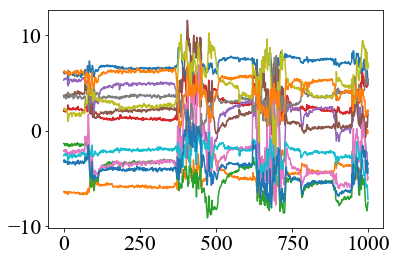

In [8]:
plt.plot(latents['test'][2]);

In [9]:
latents_trial=latents['test'][2]
plotting_latents = latents_trial + spc * np.arange(n_latents)
ax.imshow(states_trial[None,:],
           aspect="auto",
           extent=(0, len(latents_trial), min(-spc-1,np.min(plotting_latents)), max(spc*n_latents,np.max(plotting_latents))),
           cmap="jet", alpha=0.5)
ax.plot(plotting_latents, '-k', lw=1)

NameError: name 'n_latents' is not defined

In [ ]:
labs = ['musall','steinmetz','steinmetz-face','datta']
dataset_names = ['WFCI','NP','NP-zoom','Kinect']

for i_lab, lab in enumerate(labs):
    print(lab)
    hparams={}
    hparams['n_arhmm_states']=n_states
    hparams['kappa']= kappa
    hparams['noise_type']='gaussian'

    hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
    hparams['data_dir'] = '/Volumes/paninski-locker/data/'

    get_lab_example(hparams, lab)
    
    sess_dir = os.path.join(
                hparams['tt_save_path'], hparams['lab'], hparams['expt'],
                hparams['animal'], hparams['session'])
    results_dir = os.path.join(
        sess_dir, 'arhmm',
        '%02i_latents' % hparams['n_ae_latents'],
        '%02i_states' % hparams['n_arhmm_states'],
        '%.0e_kappa' % hparams['kappa'],
        hparams['noise_type'],
        'diff_init_grid_search')
    
    ## Get best version/model

    best_version = get_best_model_version(results_dir,measure='val_ll',best_def='max')[0]
    hmm = pickle.load(open(os.path.join(results_dir,best_version,'best_val_model.pt'),'rb'))

    
    ## Get latents
    hparams=[]
    hparams = pickle.load(open(os.path.join(results_dir,best_version,'meta_tags.pkl'),'rb'))
    print('best n lags '+str(hparams['n_lags']))
    hparams['ae_model_path'] = basedir+hparams['ae_model_path'].split('results/')[1]
    all_latents = pickle.load(open(os.path.join(hparams['ae_model_path'],'latents.pkl'),'rb')) 
    copyfile(os.path.join(results_dir,best_version,'syllable_behavior_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'_nlags_'+str(hparams['n_lags'])+'.mp4'),'behavenet_figs/'+dataset_names[i_lab]+'_syllable_behavior_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'_nlags_'+str(hparams['n_lags'])+'.mp4')
    
    # Get real latents/states

    trial_idxs = {}
    latents={}
    states={}
    for data_type in ['train','val','test']:
        trial_idxs[data_type] = all_latents['trials'][data_type]
        latents[data_type] = [all_latents['latents'][i_trial] for i_trial in trial_idxs[data_type]]
        states[data_type] = [hmm.most_likely_states(x) for x in latents[data_type]]

    # Get generative latents/states
    generative_states = []
    generative_latents = []
    for i in range(len(latents['test'])):
        these_generative_states, these_generative_latents, prior_states = hmm.sample(latents['test'][0].shape[0]+700)
        generative_states.append(these_generative_states[700:])
        generative_latents.append(these_generative_latents[700:])
        

    ## Make real vs generated videos
    hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
    hparams['data_dir'] = '/Volumes/paninski-locker/data/'

    hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
    ids = {
        'lab': hparams['lab'],
        'expt': hparams['expt'],
        'animal': hparams['animal'],
        'session': hparams['session']}
    data_generator = ConcatSessionsGenerator(
        hparams['data_dir'], ids,
        signals=signals, transforms=transforms, load_kwargs=load_kwargs,
        device=hparams['device'], as_numpy=hparams['as_numpy'],
        batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])


    hparams['dataset_name']=dataset_names[i_lab]
    hparams['lab_example']=lab

    make_real_vs_nonconditioned_generated_movies('behavenet_figs2/', hparams, latents['test'], generative_latents[4:], data_generator, trial_idxs=trial_idxs['test'])


In [ ]:
make_real_vs_nonconditioned_generated_movies('behavenet_figs/', hparams, latents['test'], generative_latents[4:], data_generator, trial_idxs=trial_idxs['test'])


In [ ]:
plt.plot(generative_latents[4]);

In [ ]:
plt.plot(latents['test'][2]);

In [ ]:
# filepath='behavenet_figs/'
# hparams=[]
# hparams = pickle.load(open(os.path.join(results_dir,best_version,'meta_tags.pkl'),'rb'))

# hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
# hparams['data_dir'] = '/Volumes/paninski-locker/data/'

# hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
# ids = {
#     'lab': hparams['lab'],
#     'expt': hparams['expt'],
#     'animal': hparams['animal'],
#     'session': hparams['session']}
# data_generator = ConcatSessionsGenerator(
#     hparams['data_dir'], ids,
#     signals=signals, transforms=transforms, load_kwargs=load_kwargs,
#     device=hparams['device'], as_numpy=hparams['as_numpy'],
#     batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])



# ae_model_file = os.path.join(ae_model_path,'best_val_model.pt')
# ae_arch = pickle.load(open(os.path.join(ae_model_path,'meta_tags.pkl'),'rb'))
# ae_model = AE(ae_arch)
# ae_model.load_state_dict(torch.load(ae_model_file, map_location=lambda storage, loc: storage))
# ae_model.eval()



# make_syllable_movies(hmm, ae_model, filepath=filepath, hparams=hparams, latents=latents['test'], states=states['test'], trial_idxs=trial_idxs['test'], data_generator=data_generator,min_threshold=1)



In [ ]:
# ## Plot number of lags vs validation ll

# sess_dir = os.path.join(
#             hparams['tt_save_path'], hparams['lab'], hparams['expt'],
#             hparams['animal'], hparams['session'])
# results_dir = os.path.join(
#     sess_dir, 'arhmm',
#     '%02i_latents' % hparams['n_ae_latents'],
#     '%02i_states' % hparams['n_arhmm_states'],
#     '%.0e_kappa' % hparams['kappa'],
#     hparams['noise_type'],
#     'test_tube_data',
#     'diff_init_grid_search')


# ver_dirs = os.listdir(results_dir)

# lag_vec = []
# version_vec = []
# val_ll = []
# for ver_dir in ver_dirs:
#     this_path = os.path.join(results_dir,ver_dir)
#     meta_tags = pickle.load(open(os.path.join(this_path,'meta_tags.pkl'),'rb'))
#     if meta_tags['training_completed']:
#         lag_vec.append(meta_tags['n_lags'])
#         version_vec.append(ver_dir)
#         metrics = pd.read_csv(os.path.join(this_path,'metrics.csv'))
#         val_ll.append(metrics['val_ll'][0])
# plt.plot(lag_vec,val_ll,'ok')

In [ ]:
# ## Get data generator
# hparams=[]
# hparams = pickle.load(open(os.path.join(results_dir,best_version,'meta_tags.pkl'),'rb'))

# hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
# hparams['data_dir'] = '/Volumes/paninski-locker/data/'

# hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
# ids = {
#     'lab': hparams['lab'],
#     'expt': hparams['expt'],
#     'animal': hparams['animal'],
#     'session': hparams['session']}
# data_generator = ConcatSessionsGenerator(
#     hparams['data_dir'], ids,
#     signals=signals, transforms=transforms, load_kwargs=load_kwargs,
#     device=hparams['device'], as_numpy=hparams['as_numpy'],
#     batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])


In [ ]:
# fig, axes = plt.subplots(4,2,sharex=True,sharey=True)

# ## Posteriors
# which_trials = np.arange(0,len(latents))
# np.random.shuffle(which_trials)
# for i_ex in range(4):
#     tt = hmm.expected_states(latents[which_trials[i_ex]])
#     axes[i_ex][0].imshow(tt[0].T,cmap='gray_r',aspect=30)

#     rr = hmm.sample(1000)
#     axes[i_ex][1].imshow(rr[2].T,cmap='gray_r',aspect=30)
    
# plt.tight_layout()

# axes[3][0].set_xlabel('Time (frames)')
# axes[3][1].set_xlabel('Time (frames)')

# axes[0][0].set_title('Posterior samples')
# axes[0][1].set_title('Prior samples')

#plt.savefig('posterior_vs_prior_kappa_1e6.png',dpi=200)

In [ ]:
## Make video


